In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Relaxtion ##

A simple code "example" of the relaxation method.
Solves $d^2\Phi/dx^2 = 0$ with $\Phi(0)=1$ and $\Phi(1)=0$ using what is possibly the simplest iteration scheme.

Discretize the spatial coordinate ($x$) on a regular grid: $x_i=ih$ with $i$ ($0\le i\le N$) an integer, $h=1/N$ and $N+1$ the number of grid points.
We start with the 1D version of
$$
  \nabla^2\Phi = f \quad{\rm with}\quad
  \nabla^2\Phi \approx \frac{\Phi(x+h)-2\Phi(x)+\Phi(x-h)}{h^2}
$$
with $f=-4\pi\rho=0$ for all interior points $0<i<N$.  By rewriting the Poisson equation as
$$
  \Phi_i = \frac{1}{2}\left( \Phi_{i+1} + \Phi_{i-1} - h^2f_i \right)
$$
we get an iterative method for solution (this technique is known as the [Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method) in linear algebra).

In [2]:
def solve(phi0=1,phi1=0,n=10,Niter=50,verbose=False):
    """A not-very-optimized but (hopefully) easy to read relaxation code."""
    hh      = 1.0/float(n)
    xi      = np.linspace(0,1,n+1)
    ff      = np.zeros(n+1)
    phi     = np.zeros(n+1)
    phi[ 0] = phi0
    phi[-1] = phi1
    #
    for iter in range(Niter):
        phi_old = phi
        for i in range(1,n):
          phi[i] = 0.5*(phi_old[i-1]+phi_old[i+1]-hh**2*ff[i])
        if verbose:
            print(phi)
    #
    exact = 1-xi
    return( (phi,exact) )
    #

In [3]:
phi,exact = solve(Niter=25)
for i in range(phi.size):
        print("{:3d} {:10.5f} {:10.5f} {:10.3f}".format(i,phi[i],exact[i],\
          100.*(phi[i]-exact[i])/(exact[i]+1e-10)))

  0    1.00000    1.00000      0.000
  1    0.88373    0.90000     -1.808
  2    0.77056    0.80000     -3.680
  3    0.66147    0.70000     -5.504
  4    0.55693    0.60000     -7.179
  5    0.45693    0.50000     -8.614
  6    0.36104    0.40000     -9.739
  7    0.26848    0.30000    -10.505
  8    0.17822    0.20000    -10.888
  9    0.08911    0.10000    -10.888
 10    0.00000    0.00000      0.000


Let's look at the error as a function of the number of iterations, for 10 grid points.

Text(0.5, 0, '$x$')

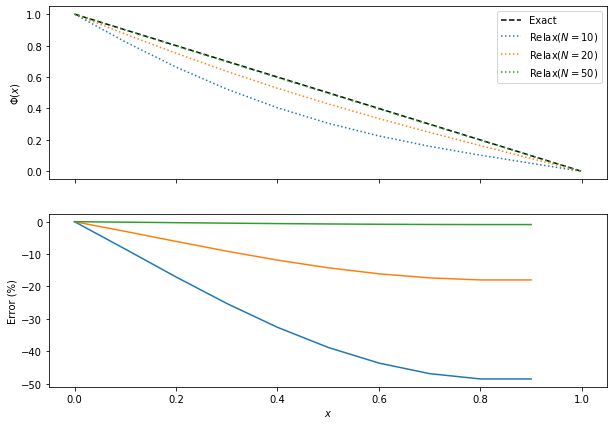

In [4]:
n=10
fig,ax = plt.subplots(2,1,figsize=(10,7),sharex=True)
phi,exact = solve(n=n,Niter=1)
xx = np.linspace(0.,1.,phi.size,endpoint=True)
ax[0].plot(xx,exact,'k--',label='Exact')
for Niter in [10,20,50]:
    phi,exact = solve(n=n,Niter=Niter)
    ax[0].plot(xx,phi,':',label="Relax($N={:3d}$)".format(Niter))
    ax[1].plot(xx[:-1],(100.*(phi-exact)/(exact+1e-10))[:-1],'-')
ax[0].legend()
ax[0].set_ylabel(r'$\Phi(x)$')
ax[1].set_ylabel(r'Error (%)')
ax[1].set_xlabel(r'$x$')

Now let's look at how the rate of convergence slows down as we increase the number of grid points.

Text(0.5, 0, '$x$')

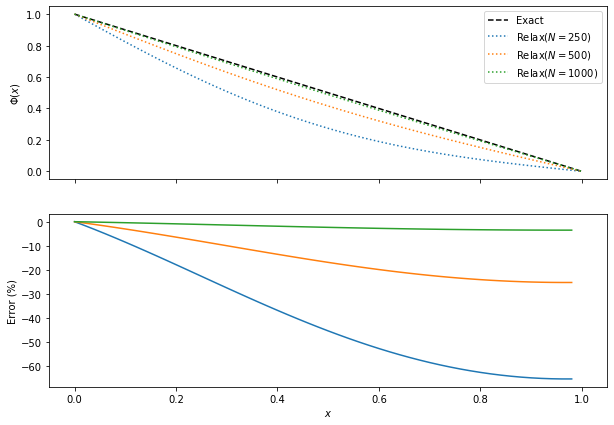

In [5]:
n=50
fig,ax = plt.subplots(2,1,figsize=(10,7),sharex=True)
phi,exact = solve(n=n,Niter=1)
xx = np.linspace(0.,1.,phi.size,endpoint=True)
ax[0].plot(xx,exact,'k--',label='Exact')
for Niter in [250,500,1000]:
    phi,exact = solve(n=n,Niter=Niter)
    ax[0].plot(xx,phi,':',label="Relax($N={:3d}$)".format(Niter))
    ax[1].plot(xx[:-1],(100.*(phi-exact)/(exact+1e-10))[:-1],'-')
ax[0].legend()
ax[0].set_ylabel(r'$\Phi(x)$')
ax[1].set_ylabel(r'Error (%)')
ax[1].set_xlabel(r'$x$')

Note how much more slowly the relaxation converged when we increased the number of grid points!  Even with 250 iterations we have a huge error near $x=1$ whereas before we were very well converged by this point.  To try to understand this let's consider the convergence rate of the algorithm.

### Convergence vs wavenumber ###

Let's study the rate of convergence of our relaxation algorithm to see what's causing the biggest problems.  This insight will also hint at the solution (e.g. multigrid relaxation).

For simplicity consider the highly trivial problem
$$
  -\Phi_{j-1} + 2\Phi_j - \Phi_{j+1} = 0 \quad , \quad
   \Phi_0 = \Phi_n = 0
$$
for $1\le j\le n-1$.  Clearly this has the solution $\Phi\equiv 0$, so at any point in our iteration the error in our approximation, $\Phi$, is just $-\Phi$.

Imagine we started our iteration assuming a plane-wave solution:
$$
  \Phi_j = \sin\left(\frac{jk\pi}{n}\right)
$$
with wavenumber $k$ (note this satisfies our boundary conditions at $j=0$ and $j=n$).

In [6]:
def solve(k=1,n=10,Niter=50):
    """Modified "trivial" relaxation code, starting with plane waves."""
    hh      = 1.0/float(n)
    xi      = np.linspace(0,1,n+1)
    ff      = np.zeros(n+1)
    phi     = np.sin(np.pi*k*xi)
    #
    for iter in range(Niter):
        phi_old = phi
        for i in range(1,n):
          phi[i] = 0.5*(phi_old[i-1]+phi_old[i+1]-hh**2*ff[i])
    return(phi)
    #

Text(0.5, 0, '$x$')

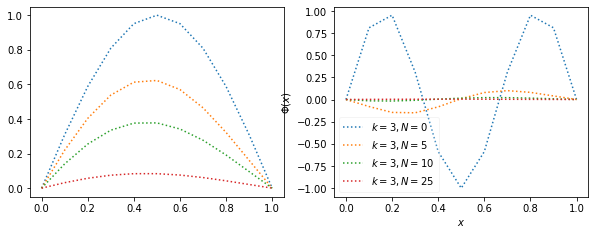

In [7]:
n=10
fig,ax = plt.subplots(1,2,figsize=(10,3.5))
xx = np.linspace(0.,1.,n+1,endpoint=True)
for Niter in [0,5,10,25]:
    for i,k in enumerate([1,3]):
        phi = solve(k=k,n=n,Niter=Niter)
        ax[i].plot(xx,phi,':',label="$k={:2d}, N={:3d}$".format(k,Niter))
ax[i].legend(framealpha=0.2)
ax[i].set_ylabel(r'$\Phi(x)$')
ax[i].set_xlabel(r'$x$')

This example clearly illustrates that the high $k$ modes are converging very quickly, while the low $k$ modes are converging much more slowly.  What is `low` and `high` in terms of $k$ depends upon the size of the grid.  For example let's make exactly the same figure but now with more grid points:

Text(0.5, 0, '$x$')

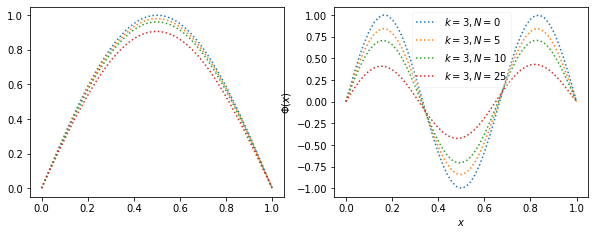

In [8]:
n=50
fig,ax = plt.subplots(1,2,figsize=(10,3.5))
xx = np.linspace(0.,1.,n+1,endpoint=True)
for Niter in [0,5,10,25]:
    for i,k in enumerate([1,3]):
        phi = solve(k=k,n=n,Niter=Niter)
        ax[i].plot(xx,phi,':',label="$k={:2d}, N={:3d}$".format(k,Niter))
ax[i].legend(framealpha=0.2)
ax[i].set_ylabel(r'$\Phi(x)$')
ax[i].set_xlabel(r'$x$')

Note that while the `physical` wavelength of the modes hasn't changed, their varation in terms of the number of grid points it takes for them to vary significantly has increased.  At the same time the convergence has decreased -- as can be seen most clearly in the right hand panel compared to our earlier result with $n=10$.

If you want you can compute the rate at which the error is decreasing with each step.  You'll find that it is `geometric`, but that the factor you are taking a power of is larger the longer the wavelength.

Since this problem is linear, if we started with a generic superposition of modes and iterated we would find that the high $k$ modes rapidly converged while the low $k$ modes converged quite slowly.  After a few iterations our error would be dominated by the low $k$s.

### Error analysis ###

Let us analyze this problem slightly more formally.  Let $\mathbf{v}$ be the `vector` we are trying to solve for and write our iteration as
$$
  \mathbf{v}^{(n+1)} = R\mathbf{v}^{(n)}
$$
with the superscripts labeling the iteration number and $R$ being our iteration matrix (the $R$ stands for `relaxation`).  We want to focus on the error, $\mathbf{e}$.  If $\mathbf{u}$ is the true solution and $\mathbf{v}^{(n)}$ is the approximation after $n$ iterations then $\mathbf{e}^{(n)}=\mathbf{v}^{(n)}-\mathbf{u}$:
$$
  \mathbf{e}^{(m)} = R^m\mathbf{e}^{(0)}
$$
If we decompose $\mathbf{e}^{(0)}$ into the eigenvectors of $R$, say $\mathbf{w}_k$ with eigenvalues $\lambda_k$, then after $m$ iterations the contribution of each $\mathbf{w}_k$ to the error is suppressed by $\lambda_k^m$.  As long as all of the $\lambda_k$ are strictly less than $1$ our method will converge.

(This sort of reasoning is usually developed using the theory of matrix norms.  We can define the [spectral norm](https://en.wikipedia.org/wiki/Matrix_norm) of a (symmetric) matrix as
$$
  \rho(R) = \mathrm{max\ absolute\ eigenvalue\ of\ }R
$$
Then by the properties of matrix norms we have
$$
  ||\mathbf{e}^{(m)}|| = ||R||^m\quad ||\mathbf{e}^{(0)}||
$$
and the error will decrease as long as $||R||<1$.)

So what are the eigenvalues and eigenvectors of $R$ in our case?  Consider a big matrix that looks like
$$
 A = \left( \begin{array}{rrrrrr}
        2 & -1 &  0 & 0  & 0 & \cdots \\
       -1 &  2 & -1 &  0 & 0 & \cdots \\
        0 & -1 &  2 & -1 & 0 & \cdots \\
   \vdots & 0 & -1 & 2 & -1 & \cdots \\
   \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
 \end{array}\right)
$$
Such a matrix has eigenvectors which are plane waves!  In fact our solutions are the $\sin(jk\pi/n)$ modes we had before.  A little bit of work with trigonometric addition formulae will convince you that the eigenvalues are $4\sin^2(k\pi/[2n])$.

In [10]:
# Let's "prove" this to ourselves for the case n=7,
# which is the largest value I am willing to type in!
A = np.array( [[ 2,-1, 0, 0, 0, 0],\
               [-1, 2,-1, 0, 0, 0],\
               [ 0,-1, 2,-1, 0, 0],\
               [ 0, 0,-1, 2,-1, 0],\
               [ 0, 0, 0,-1, 2,-1],\
               [ 0, 0, 0, 0,-1, 2]])
for k in [1,2]:
    v = np.sin(k*np.pi*np.arange(1,7)/7.)
    print("k=",k,", v=",v)
    #
    lam_k = 4*(np.sin(k*np.pi/(2.*7.)))**2
    print("A.v=",np.dot(A,v))
    print("l.v=",lam_k*v)
    print(" ")

k= 1 , v= [0.43388374 0.78183148 0.97492791 0.97492791 0.78183148 0.43388374]
A.v= [0.085936   0.15485131 0.19309643 0.19309643 0.15485131 0.085936  ]
l.v= [0.085936   0.15485131 0.19309643 0.19309643 0.15485131 0.085936  ]
 
k= 2 , v= [ 0.78183148  0.97492791  0.43388374 -0.43388374 -0.97492791 -0.78183148]
A.v= [ 0.58873505  0.7341406   0.32672331 -0.32672331 -0.7341406  -0.58873505]
l.v= [ 0.58873505  0.7341406   0.32672331 -0.32672331 -0.7341406  -0.58873505]
 


This is almost our iteration.  Our Jacobi iteration was to split off the diagonal piece of $A$ (twice the identity matrix) and move the off-diagonal bits to the rhs.  The eigenvalues of the unit matrix are all 1, so this means the eigenvalues of our iteration are $1-2\sin^2(k\pi/[2n])$.

Now we can see why the convergence is slow for the low $k$ modes, but high for the high $k$ modes!  Our error goes as $\lambda_k^m$.  When $k$ is small, $\lambda_k$ is close to 1 so this takes a long time to drop.  However when $k$ is large $\lambda_k$ is smaller and $\lambda_k^m$ drops to zero quickly.  You can also see how increasing $n$ is making our life more difficult.

With a little thought you imagine weighting our updates to be a linear combination of $\omega$ times our Jacobi update plus $1-\omega$ times our earlier solution.  This is known as the `weighted Jacobi method` and choosing something like $\omega=2/3$ is a pretty good choice.  You should be able to argue this based on the analysis above.  This helps somewhat, however our basic problem still remains -- the low $k$ modes converge slowly.

### Next steps ###

Given our analytic study of the rate of convergence we can devise methods to accelerate the convergence of the modes which converge the slowest -- this leads to "multigrid", which is one of the most useful techniques for solving PDEs on a grid (especially in the era of massively parallel computing since one can frequently efficiently interleave communication and computation).  The essential idea is to have a hierarchy of grids, each one finer than its parent.  You iterate on the fine grids to get the high $k$ modes to converge, and on the coarse grids to get the low $k$ modes to converge.  By (cleverly) moving up and down through the hierarchy you can get all of the modes to converge quickly.

A useful introduction to multigrid methods is the slim volume ["A multigrid tutorial" by Briggs, et al.](https://www.amazon.com/Multigrid-Tutorial-William-L-Briggs/dp/0898714621).  You can also check out the multigrid notebook.